## Import Necessary Packages

In [5]:
import pickle
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import proplot as pplt
from matplotlib.lines import Line2D
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

## Load Results

In [22]:
FILEDIR = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/data/'

ytrue  = xr.open_dataset(f'{FILEDIR}/processed/valid.h5',engine='h5netcdf')['pr']
ypred1 = xr.open_dataarray(f'{FILEDIR}/results/pod_bw_01_valid_pr.nc',engine='h5netcdf')
ypred2 = xr.open_dataarray(f'{FILEDIR}/results/pod_bw_001_valid_pr.nc',engine='h5netcdf')
ypred3 = xr.open_dataarray(f'{FILEDIR}/results/pod_bw_0001_valid_pr.nc',engine='h5netcdf')
ypredlist = [ypred1,ypred2,ypred3]

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

def align_flatten(y_true_da, y_pred_da):
    """Align coords, flatten to 1D numpy arrays, drop nonfinite."""
    yt = y_true_da.values.reshape(-1)
    yp = y_pred_da.values.reshape(-1)
    m = np.isfinite(yt) & np.isfinite(yp)
    return yt[m], yp[m]

def metrics(y, yhat):
    """RMSE, MAE, R^2."""
    err = yhat - y
    rmse = float(np.sqrt(np.mean(err**2)))
    mae  = float(np.mean(np.abs(err)))
    ybar = float(np.mean(y))
    ss_tot = float(np.sum((y - ybar)**2))
    ss_res = float(np.sum(err**2))
    r2 = float('nan') if ss_tot <= 0 else 1.0 - ss_res/ss_tot
    return rmse, mae, r2

pairs = [
    ("bw=0.1",  ypredbw01),
    ("bw=0.01", ypredbw001),
    ("bw=0.001",ypredbw0001),
]

# Prepare figure
fig, axes = plt.subplots(1, 3,constrained_layout=True)
axes = np.atleast_1d(axes)

for ax, (label, ypred_da) in zip(axes, pairs):
    yt, yp = align_flatten(ytrue, ypred_da)

    # Robust axis limits (clip to 99.9th percentile)
    xmin = 0.0
    xmax = np.percentile(np.concatenate([yt, yp]), 99.9)

    hb = ax.hexbin(
        yt, yp, gridsize=200, bins='log',
        extent=(xmin, xmax, xmin, xmax), mincnt=1
    )
    ax.plot([xmin, xmax], [xmin, xmax], 'k--', lw=1.0, alpha=0.8)

    rmse, mae, r2 = metrics(yt, yp)
    ax.set_title(f"POD {label}  |  RMSE={rmse:.2f}  MAE={mae:.2f}  R²={r2:.3f}")
    ax.set_xlabel("True precipitation (mm/day)")
    ax.set_ylabel("Predicted precipitation (mm/day)")
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label("log10(count)")

plt.show()

## Functions

In [4]:
def create_log_rain_bins(binspacing=0.08,minleftedge=0.001,maxcenter=1000):
    firstcenter = minleftedge/(1-binspacing/2)
    center      = firstcenter
    bincenters  = []
    binwidths   = []
    while center<=maxcenter:
        width = center*(binspacing)
        bincenters.append(center)
        binwidths.append(width)
        center  = center*(1+binspacing)
    bincenters  = np.array(bincenters)
    binwidths   = np.array(binwidths)
    binedges    = np.zeros(len(bincenters)+1)
    binedges[0] = bincenters[0]-binwidths[0]/2
    for i in range(len(bincenters)):
        binedges[i+1] = bincenters[i]+binwidths[i]/2
    return bincenters,binwidths,binedges

def get_hist(ytrue,ypred):
    nonzeromask  = (ytrue>0)&(ypred>0)
    ytruenonzero = ytrue[nonzeromask]
    yprednonzero = ypred[nonzeromask]
    _,_,binedges = create_log_rain_bins()
    counts,_,_   = np.histogram2d(ytruenonzero,yprednonzero,bins=[binedges,binedges])
    countsmasked = np.ma.masked_where(counts==0,counts)
    return countsmasked,binedges

def get_amount_dist(ydata,drythresh=0.25):
    drydays = ydata<drythresh
    wetdays = ydata[~drydays]
    totalpr = np.sum(wetdays)
    bincenters,binwidths,binedges = create_log_rain_bins()
    counts,_  = np.histogram(wetdays,bins=binedges)
    amtperbin = np.zeros_like(counts)
    for i in range(len(bincenters)):
        inbin = (wetdays>=binedges[i])&(wetdays<binedges[i+1])
        if np.any(inbin):
            amtperbin[i] = np.sum(wetdays[inbin])
    amtcontrib = amtperbin/totalpr
    return {
        'bins':bincenters,
        'widths':binwidths,
        'amtcontrib':amtcontrib,
        'amtperbin':amtperbin}

def hellinger_distance(p,q):
    minlength = min(len(p),len(q))
    p = p[:minlength]
    q = q[:minlength]
    p = p/np.sum(p)
    q = q/np.sum(q)
    return np.sqrt(0.5*np.sum((np.sqrt(p)-np.sqrt(q))**2))

In [43]:
def get_metrics(allmodels,prthresh=0):
    metricsdata = []
    for modelname,results in allmodels.items():
        ytruemodel = results['ytrue']
        ypredmodel = results['ypred']
        r2score = r2_score(ytruemodel,ypredmodel)
        mae  = mean_absolute_error(ytruemodel,ypredmodel)
        mse  = mean_squared_error(ytruemodel,ypredmodel)
        bias = np.mean(ypredmodel-ytruemodel) 
        prthresh   = 0.25
        trueevents = ytruemodel>prthresh
        predevents = ypredmodel>prthresh
        hitrate    = np.sum(trueevents&predevents)/np.sum(trueevents) if np.sum(trueevents)>0 else 0
        far        = np.sum(predevents&~trueevents)/np.sum(predevents) if np.sum(predevents)>0 else 0
        _,_,binedges = create_log_rain_bins()
        histtrue,_ = np.histogram(ytruemodel,bins=binedges,density=True)
        histpred,_ = np.histogram(ypredmodel,bins=binedges,density=True)
        hellinger  = hellinger_distance(histtrue,histpred)
        metricsdata.append({
            'name':modelname,
            'description':results['description'],
            'r2':r2score,
            'mae':mae,
            'mse':mse,
            'bias':bias,
            'hitrate':hitrate,
            'far':far,
            'hellinger':hellinger,
             'nparams':results['nparams']})
    return pd.DataFrame(metricsdata)

def get_model_color(modelname):
    if 'bw_0.1' in modelname:
        return 'red9'   
    elif 'bw_0.01' in modelname:
        return 'red6' 
    elif 'bw_0.001' in modelname:
        return 'red3'  
    elif modelname.startswith('exp_1'):
        return 'yellow3'   
    elif modelname.startswith('exp_2'):
        return 'yellow6'   
    elif modelname.startswith('exp_3'):
        return 'yellow6'   
    elif modelname.startswith('exp_4'):
        return 'green6'    
    elif modelname.startswith('exp_5'):
        return 'blue6'    
    elif modelname.startswith('exp_6'):
        return 'purple6'   
    else:
        return 'gray6'    

## Clean Precipitation

In [6]:
allmodels = {}

for modelname,results in baseresults.items():
    ypredvalues = results['ypred']
    ytruevalues = results['ytrue']  
    validmask = np.isfinite(ypredvalues) & np.isfinite(ytruevalues)
    allmodels[f'baseline_{modelname}'] = {
        'description': f"{results['description']}",
        'ypred':ypredvalues[validmask],
        'ytrue':ytruevalues[validmask],
        'nparams':results['nparams']}

for expnum,results in mlpresults.items():
    ypredvalues = results['predictions']
    ytruevalues = results['targets']
    validmask = np.isfinite(ypredvalues)&np.isfinite(ytruevalues)
    modelkey = f"exp_{expnum}"
    allmodels[modelkey] = {
        'description': f"Exp {expnum}: {results['description']}",
        'ypred':ypredvalues[validmask],
        'ytrue':ytruevalues[validmask],
        'nparams':results['n_parameters']}

print(f"Total models loaded: {len(allmodels)}")
print("Baseline models:", [k for k in allmodels.keys() if k.startswith('baseline_')])
print("MLP experiment models:", [k for k in allmodels.keys() if k.startswith('exp_')])

Total models loaded: 6
Baseline models: ['baseline_bw_0.1', 'baseline_bw_0.01', 'baseline_bw_0.001']
MLP experiment models: ['exp_1', 'exp_2', 'exp_5']


## Plot Actual vs. Predicted Precipitation

In [7]:
allvalues = []
for modelname,results in allmodels.items():
    allvalues.extend(results['ytrue'])
    allvalues.extend(results['ypred'])
allvalues = np.array(allvalues)
allvalues = allvalues[np.isfinite(allvalues)]
globalmin = np.min(allvalues) 
globalmax = np.max(allvalues)
print(f'Precipitation ranges from {globalmin:.4f} to {globalmax:.2f} mm/day')

Precipitation ranges from -0.2562 to 2849.43 mm/day


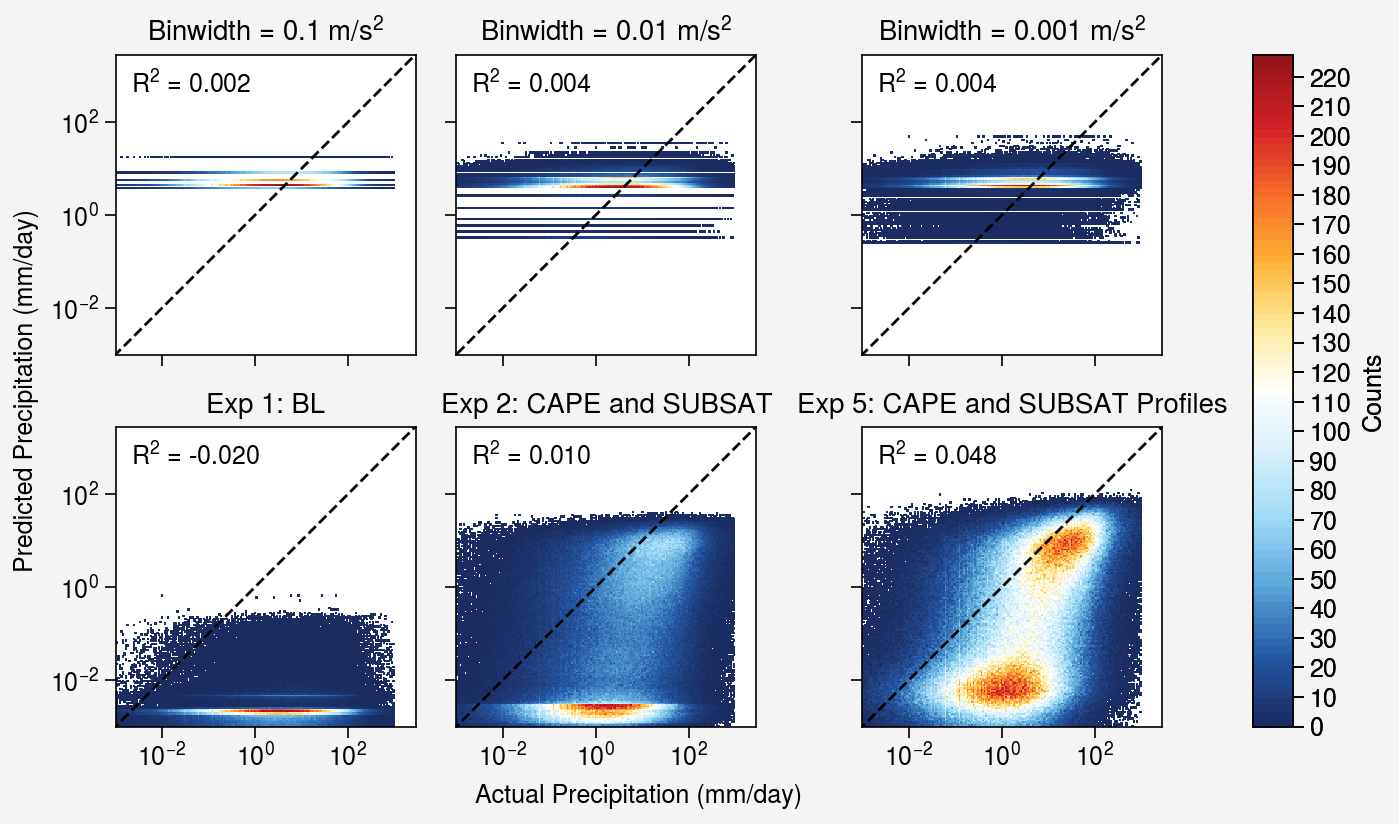

In [8]:
ticks   = [1e-4,1e-2,1e0,1e2]
ncols   = 3
nrows   = (len(allmodels)+ncols-1)//ncols
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=1.5,share=True)

for i,(modelname,results) in enumerate(allmodels.items()):
    results['ypred'] = np.maximum(results['ypred'],0)
    row = i//ncols
    col = i%ncols
    ytruemodel = results['ytrue']
    ypredmodel = results['ypred']
    r2score_val = r2_score(ytruemodel,ypredmodel)
    hist,binedges = get_hist(ytruemodel,ypredmodel)
    im = axs[row,col].pcolormesh(binedges,binedges,hist.T,cmap='ColdHot',levels=100)
    axs[row,col].plot([globalmin,globalmax],[globalmin,globalmax],'k--',linewidth=1)
    axs[row,col].text(0.05,0.95,f'R$^2$ = {r2score_val:.3f}',transform=axs[row,col].transAxes,va='top',ha='left')
    axs[row,col].format(title=results['description'])

# Hide unused subplots
for i in range(len(allmodels),nrows*ncols):
    row = i//ncols
    col = i%ncols
    axs[row,col].axis('off')
    
axs.format(xscale='log',xformatter='log',xlim=[globalmin,globalmax],xticks=ticks,xminorticks='none',
           yscale='log',yformatter='log',ylim=[globalmin,globalmax],yticks=ticks,yminorticks='none')
axs[:,0].format(ylabel='Predicted Precipitation (mm/day)')
axs[-1,:].format(xlabel='Actual Precipitation (mm/day)')

fig.colorbar(im,loc='r',label='Counts')
pplt.show()

## Testing Distributions

In [9]:
import json
import os
import h5py

DATA_DIR = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/data/processed'

def load_all_data():
    datapath = os.path.join(DATA_DIR, 'datasplits.h5')
    metadatapath = os.path.join(DATA_DIR, 'metadata.json')
    with open(metadatapath, 'r') as f:
        metadata = json.load(f)
    with h5py.File(datapath, 'r') as f:
        data = {
            'inputs_train': f['X_train'][:],
            'inputs_valid': f['X_valid'][:],
            'inputs_test': f['X_test'][:],
            'target_train': f['y_train'][:],
            'target_valid': f['y_valid'][:],
            'target_test': f['y_test'][:]}
    return data, metadata

data,metadata = load_all_data()

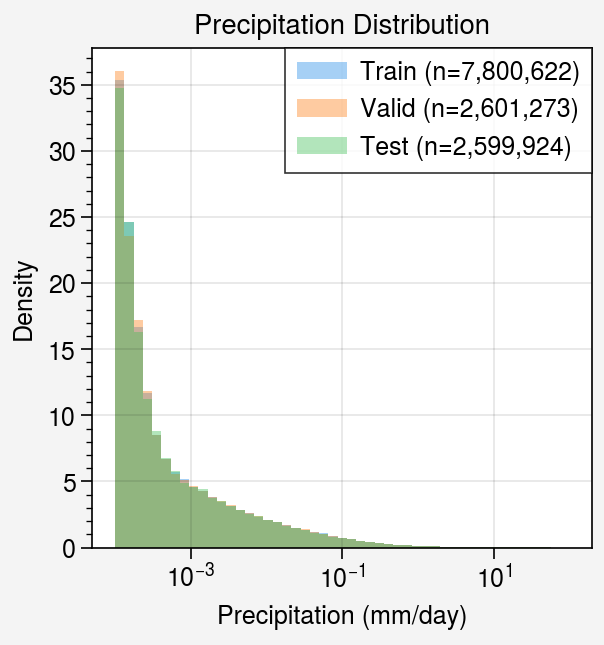

In [22]:
def plot_target_distributions(data):
    fig,ax = pplt.subplots(nrows=1,ncols=1)
    splits = ['train','valid','test']
    colors = ['blue6','orange6','green6']
    for split,color in zip(splits,colors):
        targets = data[f'target_{split}']
        targetsclean = targets[(targets>0)&np.isfinite(targets)]
        if len(targetsclean)>0:
            ax.hist(targetsclean,bins=np.logspace(-4,2,50),density=True,color=color,alpha=0.4,
                    label=f'{split.title()} (n={len(targetsclean):,})')
    ax.format(title='Precipitation Distribution',xlabel='Precipitation (mm/day)',xscale='log',xformatter='log',ylabel='Density')
    ax.legend(loc='ur',ncols=1)
    pplt.show()

plot_target_distributions(data)

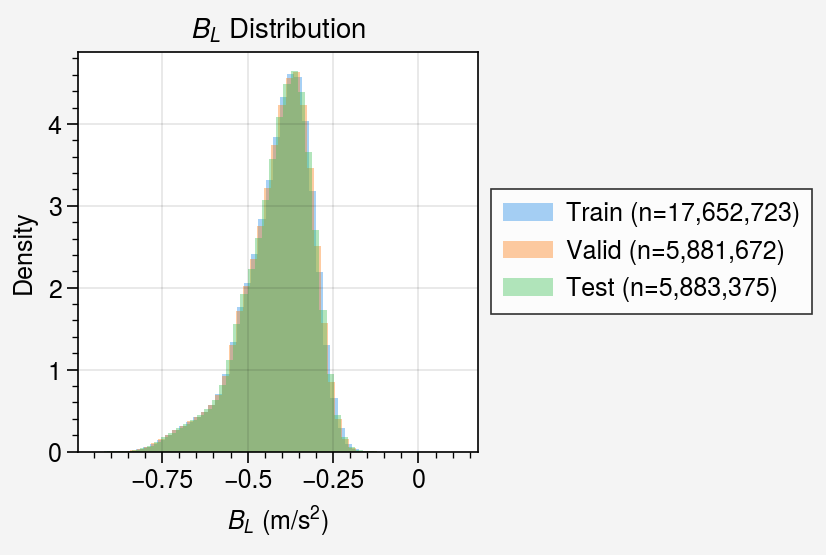

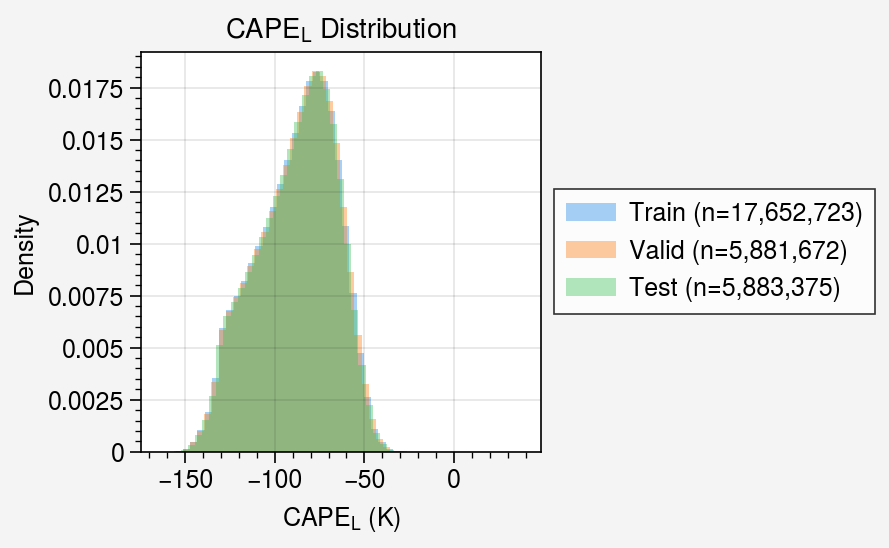

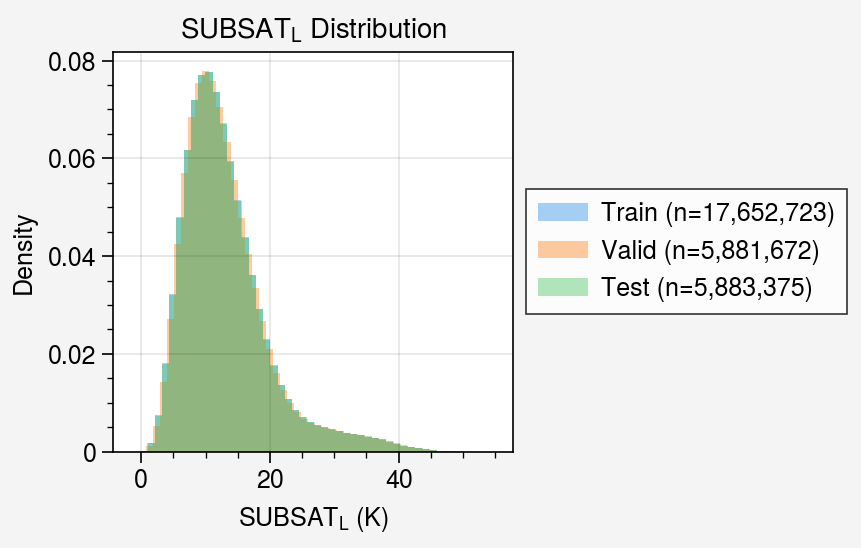

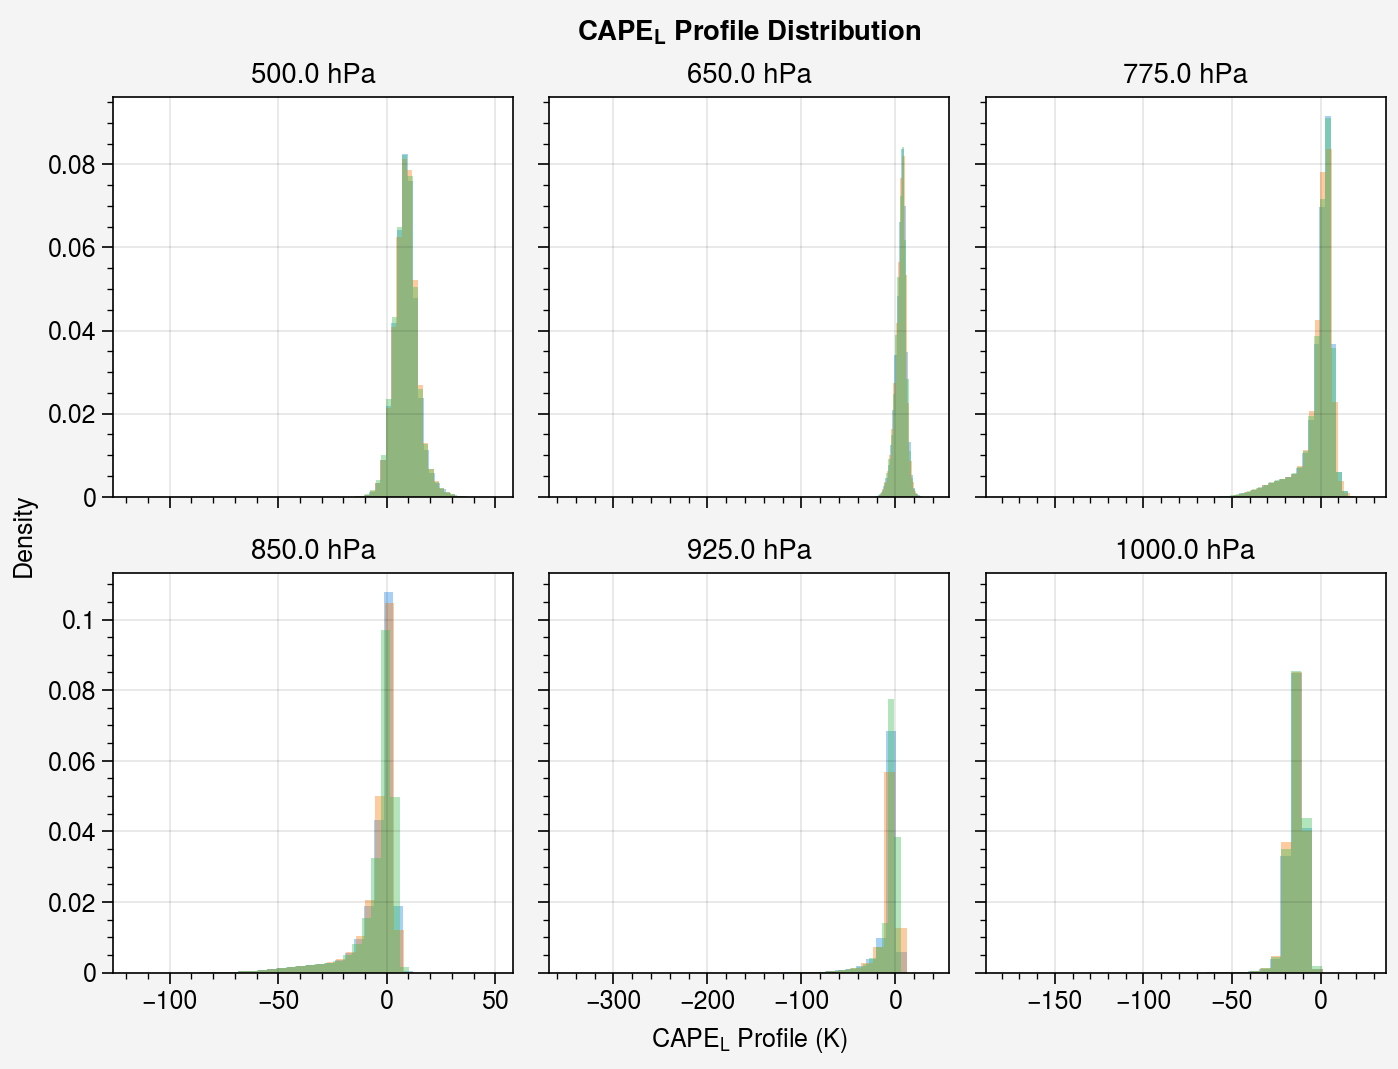

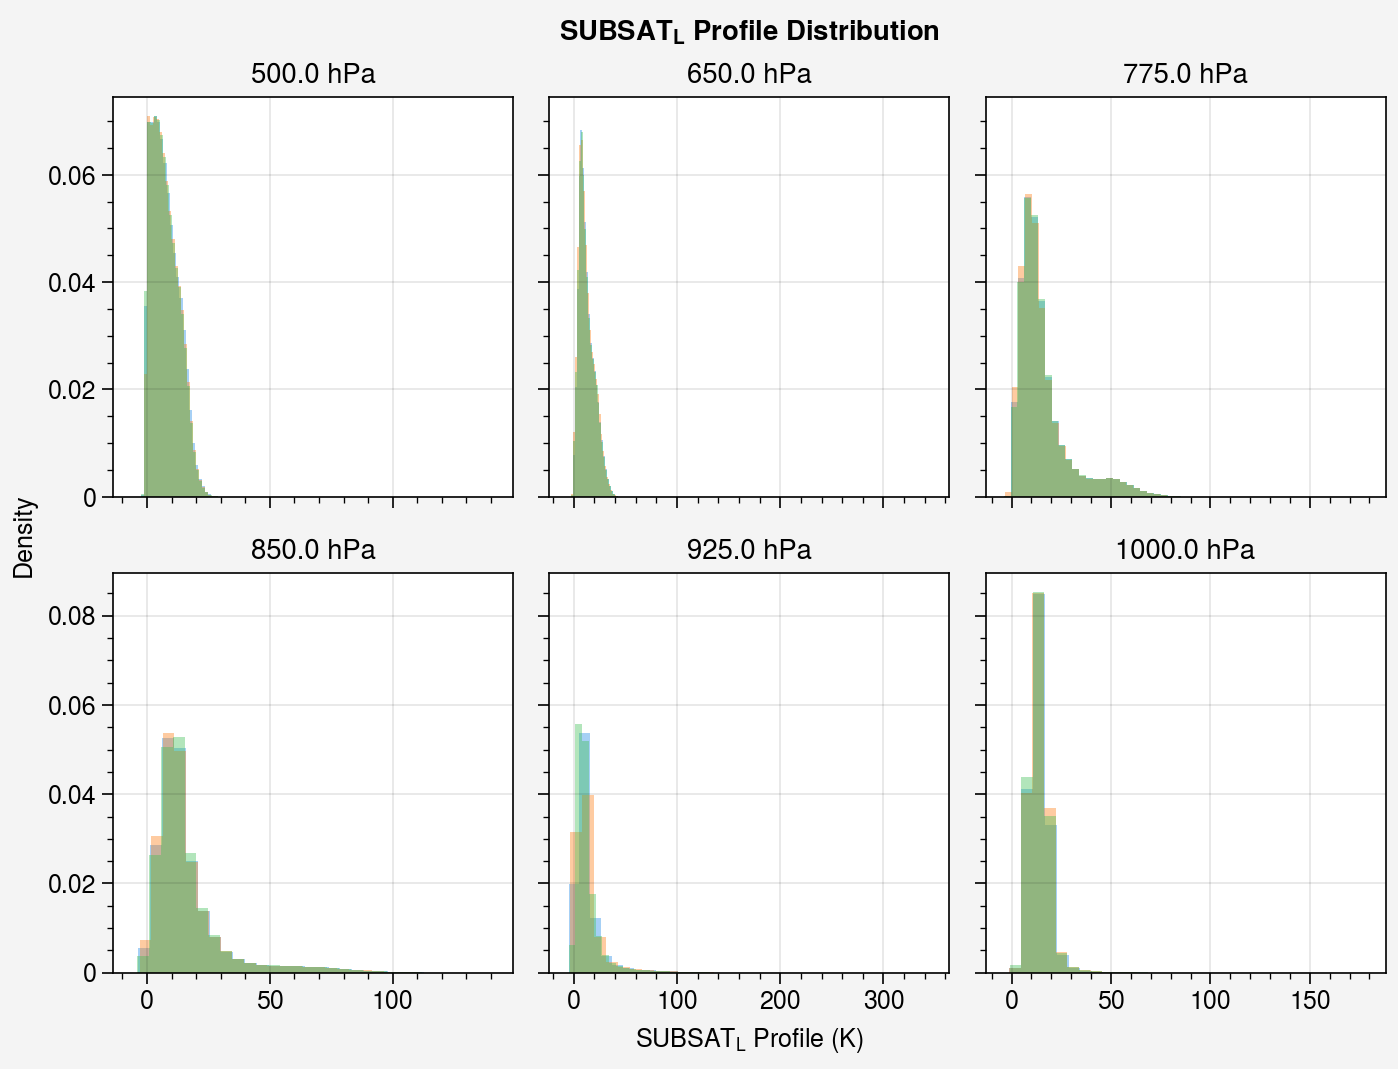

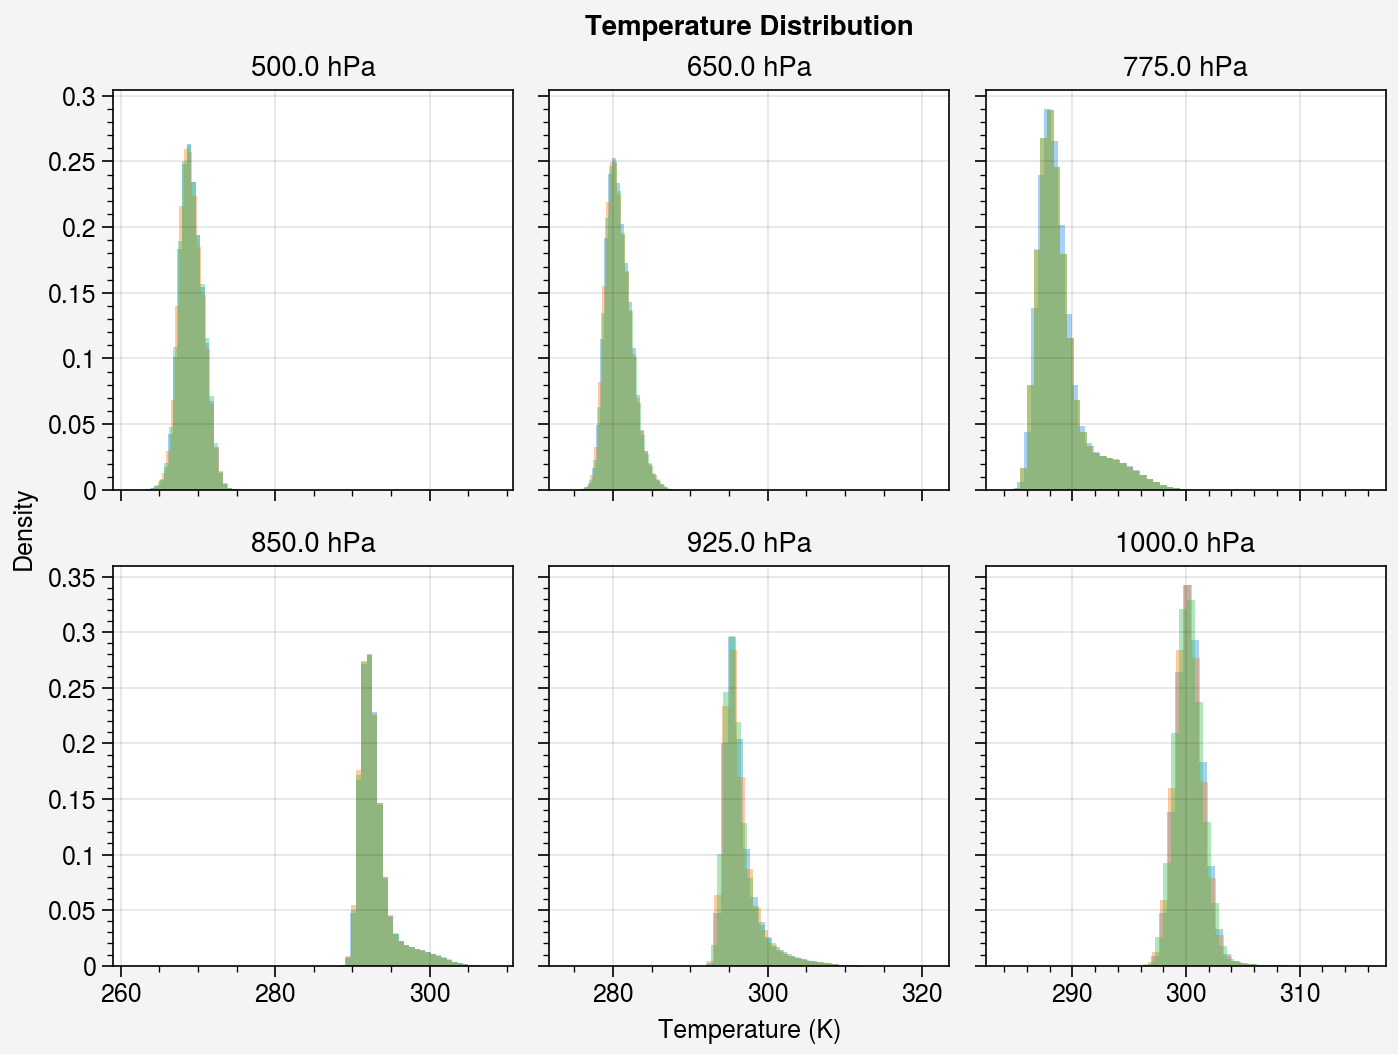

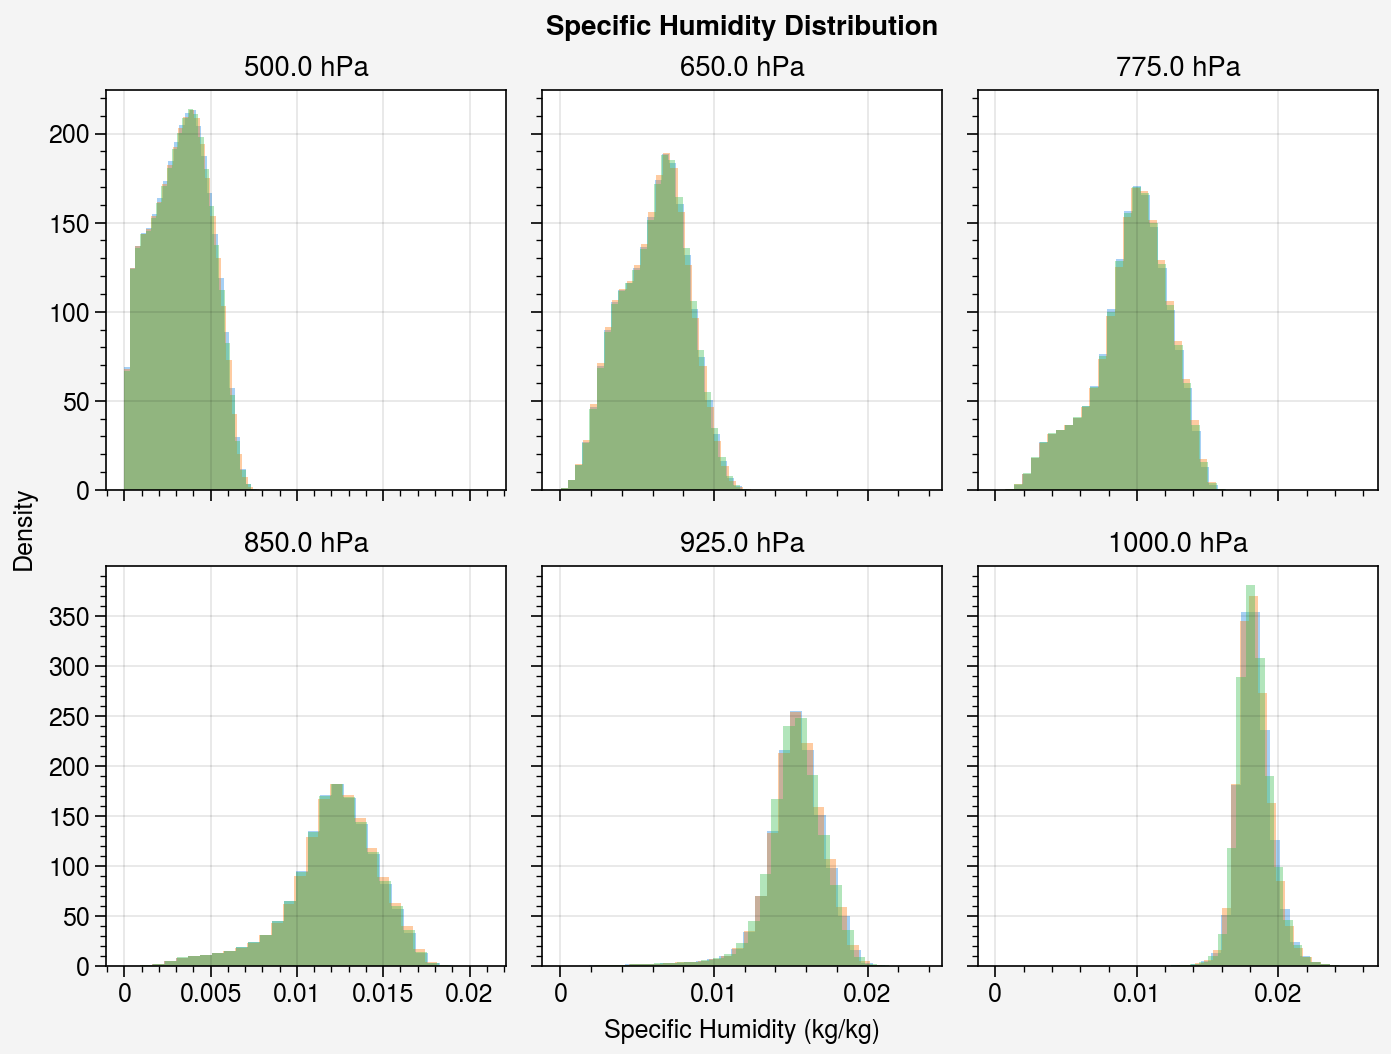

In [35]:
def plot_input_variable_distributions(data,metadata):
    inputmapping = metadata['feature_mapping']
    inputsall = {
        'train':data['inputs_train'],
        'valid':data['inputs_valid'], 
        'test':data['inputs_test']}
    splits = ['train','valid','test']
    colors = ['blue6','orange6','green6']  
    for varname,varinfo in inputmapping.items():
        columns   = varinfo['columns']
        nfeatures = varinfo['n_features']
        if nfeatures==1:
            fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=2)
            if varname=='bl':
                name  = '$\mathit{B_L}$'
                units = 'm/s$^2$'
            elif varname=='cape':
                name  ='$CAPE_L$'
                units = 'K'
            elif varname=='subsat':
                name  = '$SUBSAT_L$'
                units = 'K'
            ax.format(title=f'{name} Distribution',xlabel=f'{name} ({units})',ylabel='Density')
            for split,color in zip(splits,colors):
                featuredata  = inputsall[split][:,columns[0]]
                featureclean = featuredata[np.isfinite(featuredata)]
                ax.hist(featureclean,bins=50,density=True,color=color,alpha=0.4, 
                       label=f'{split.title()} (n={len(featureclean):,})')
            ax.legend(loc='r',ncols=1)
        else:
            nsamplefeatures = min(6,nfeatures)
            sampleindices = np.linspace(0,nfeatures-1,nsamplefeatures,dtype=int)
            fig,axs = pplt.subplots(nrows=2,ncols=3,refwidth=2)
            if varname=='t':
                name  = 'Temperature'
                units = 'K'
            elif varname=='q':
                name  = 'Specific Humidity'
                units = 'kg/kg'
            elif varname=='capeprofile':
                name  ='$CAPE_L$ Profile'
                units = 'K'
            elif varname=='subsatprofile':
                name  = '$SUBSAT_L$ Profile'
                units = 'K'
            fig.suptitle(f'{name} Distribution')
            for i,featureidx in enumerate(sampleindices):
                ax = axs[i]
                colidx = columns[featureidx]
                if 'levels' in varinfo:
                    levelname = f"{varinfo['levels'][featureidx]} hPa"
                for split,color in zip(splits,colors):
                    featuredata  = inputsall[split][:,colidx]
                    featureclean = featuredata[np.isfinite(featuredata)]
                    ax.hist(featureclean,bins=30,density=True,color=color,alpha=0.4, 
                           label=f'{split.title()}' if i==0 else "")
                ax.format(xlabel=f'{name} ({units})',ylabel='Density',title=levelname)
            for i in range(nsamplefeatures,6):
                axes[i].axis('off')
        pplt.show()
        
plot_input_variable_distributions(data,metadata)

## Plot Actual vs. Predicted Amount Distributions

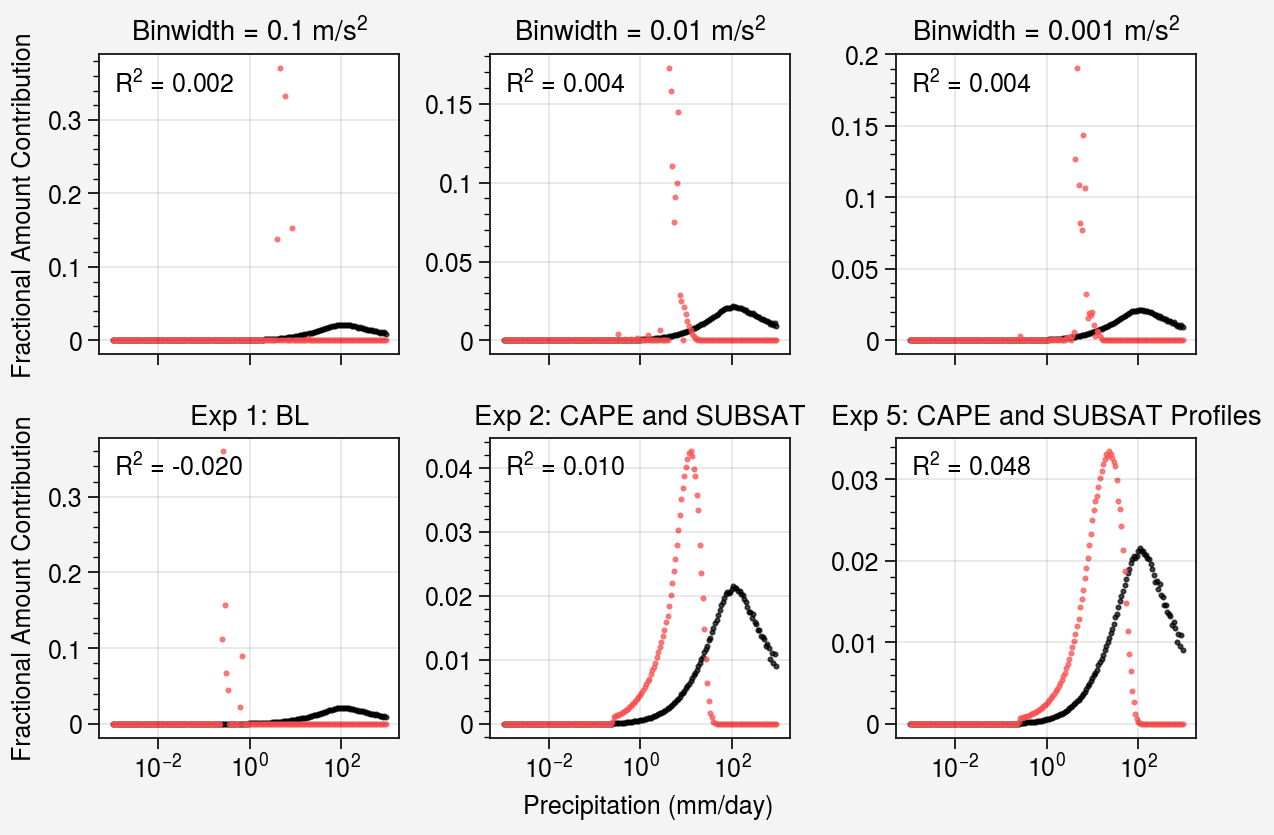

In [33]:
# ticks   = [1e-4,1e-2,1e0,1e2]
ncols   = 3
nrows   = (len(allmodels)+ncols-1)//ncols
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=1.5,sharey=False)

for i,(modelname,results) in enumerate(allmodels.items()):
    row = i//ncols
    col = i%ncols
    ytruemodel = results['ytrue']
    ypredmodel = results['ypred']
    r2score    = r2_score(ytruemodel,ypredmodel)
    disttrue   = get_amount_dist(ytruemodel)
    distpred   = get_amount_dist(ypredmodel)
    axs[row,col].scatter(disttrue['bins'],disttrue['amtcontrib'],color='k',marker='.',markersize=10,alpha=0.7,label='Actual')
    axs[row,col].scatter(distpred['bins'],distpred['amtcontrib'],color='red6',marker='.',markersize=10,alpha=0.7,label='Predicted')
    axs[row,col].text(0.05,0.95,f'R$^2$ = {r2score:.3f}',transform=axs[row,col].transAxes,va='top',ha='left')
    axs[row,col].format(title=results['description'])
for i in range(len(allmodels),nrows*ncols):
    row = i//ncols
    col = i%ncols
    axs[row,col].axis('off')

axs.format(xscale='log',xformatter='log')
axs[:,0].format(ylabel='Fractional Amount Contribution')
axs[-1,:].format(xlabel='Precipitation (mm/day)')
    
pplt.show()

## Plot Metrics

In [36]:
metricsdf = get_metrics(allmodels)

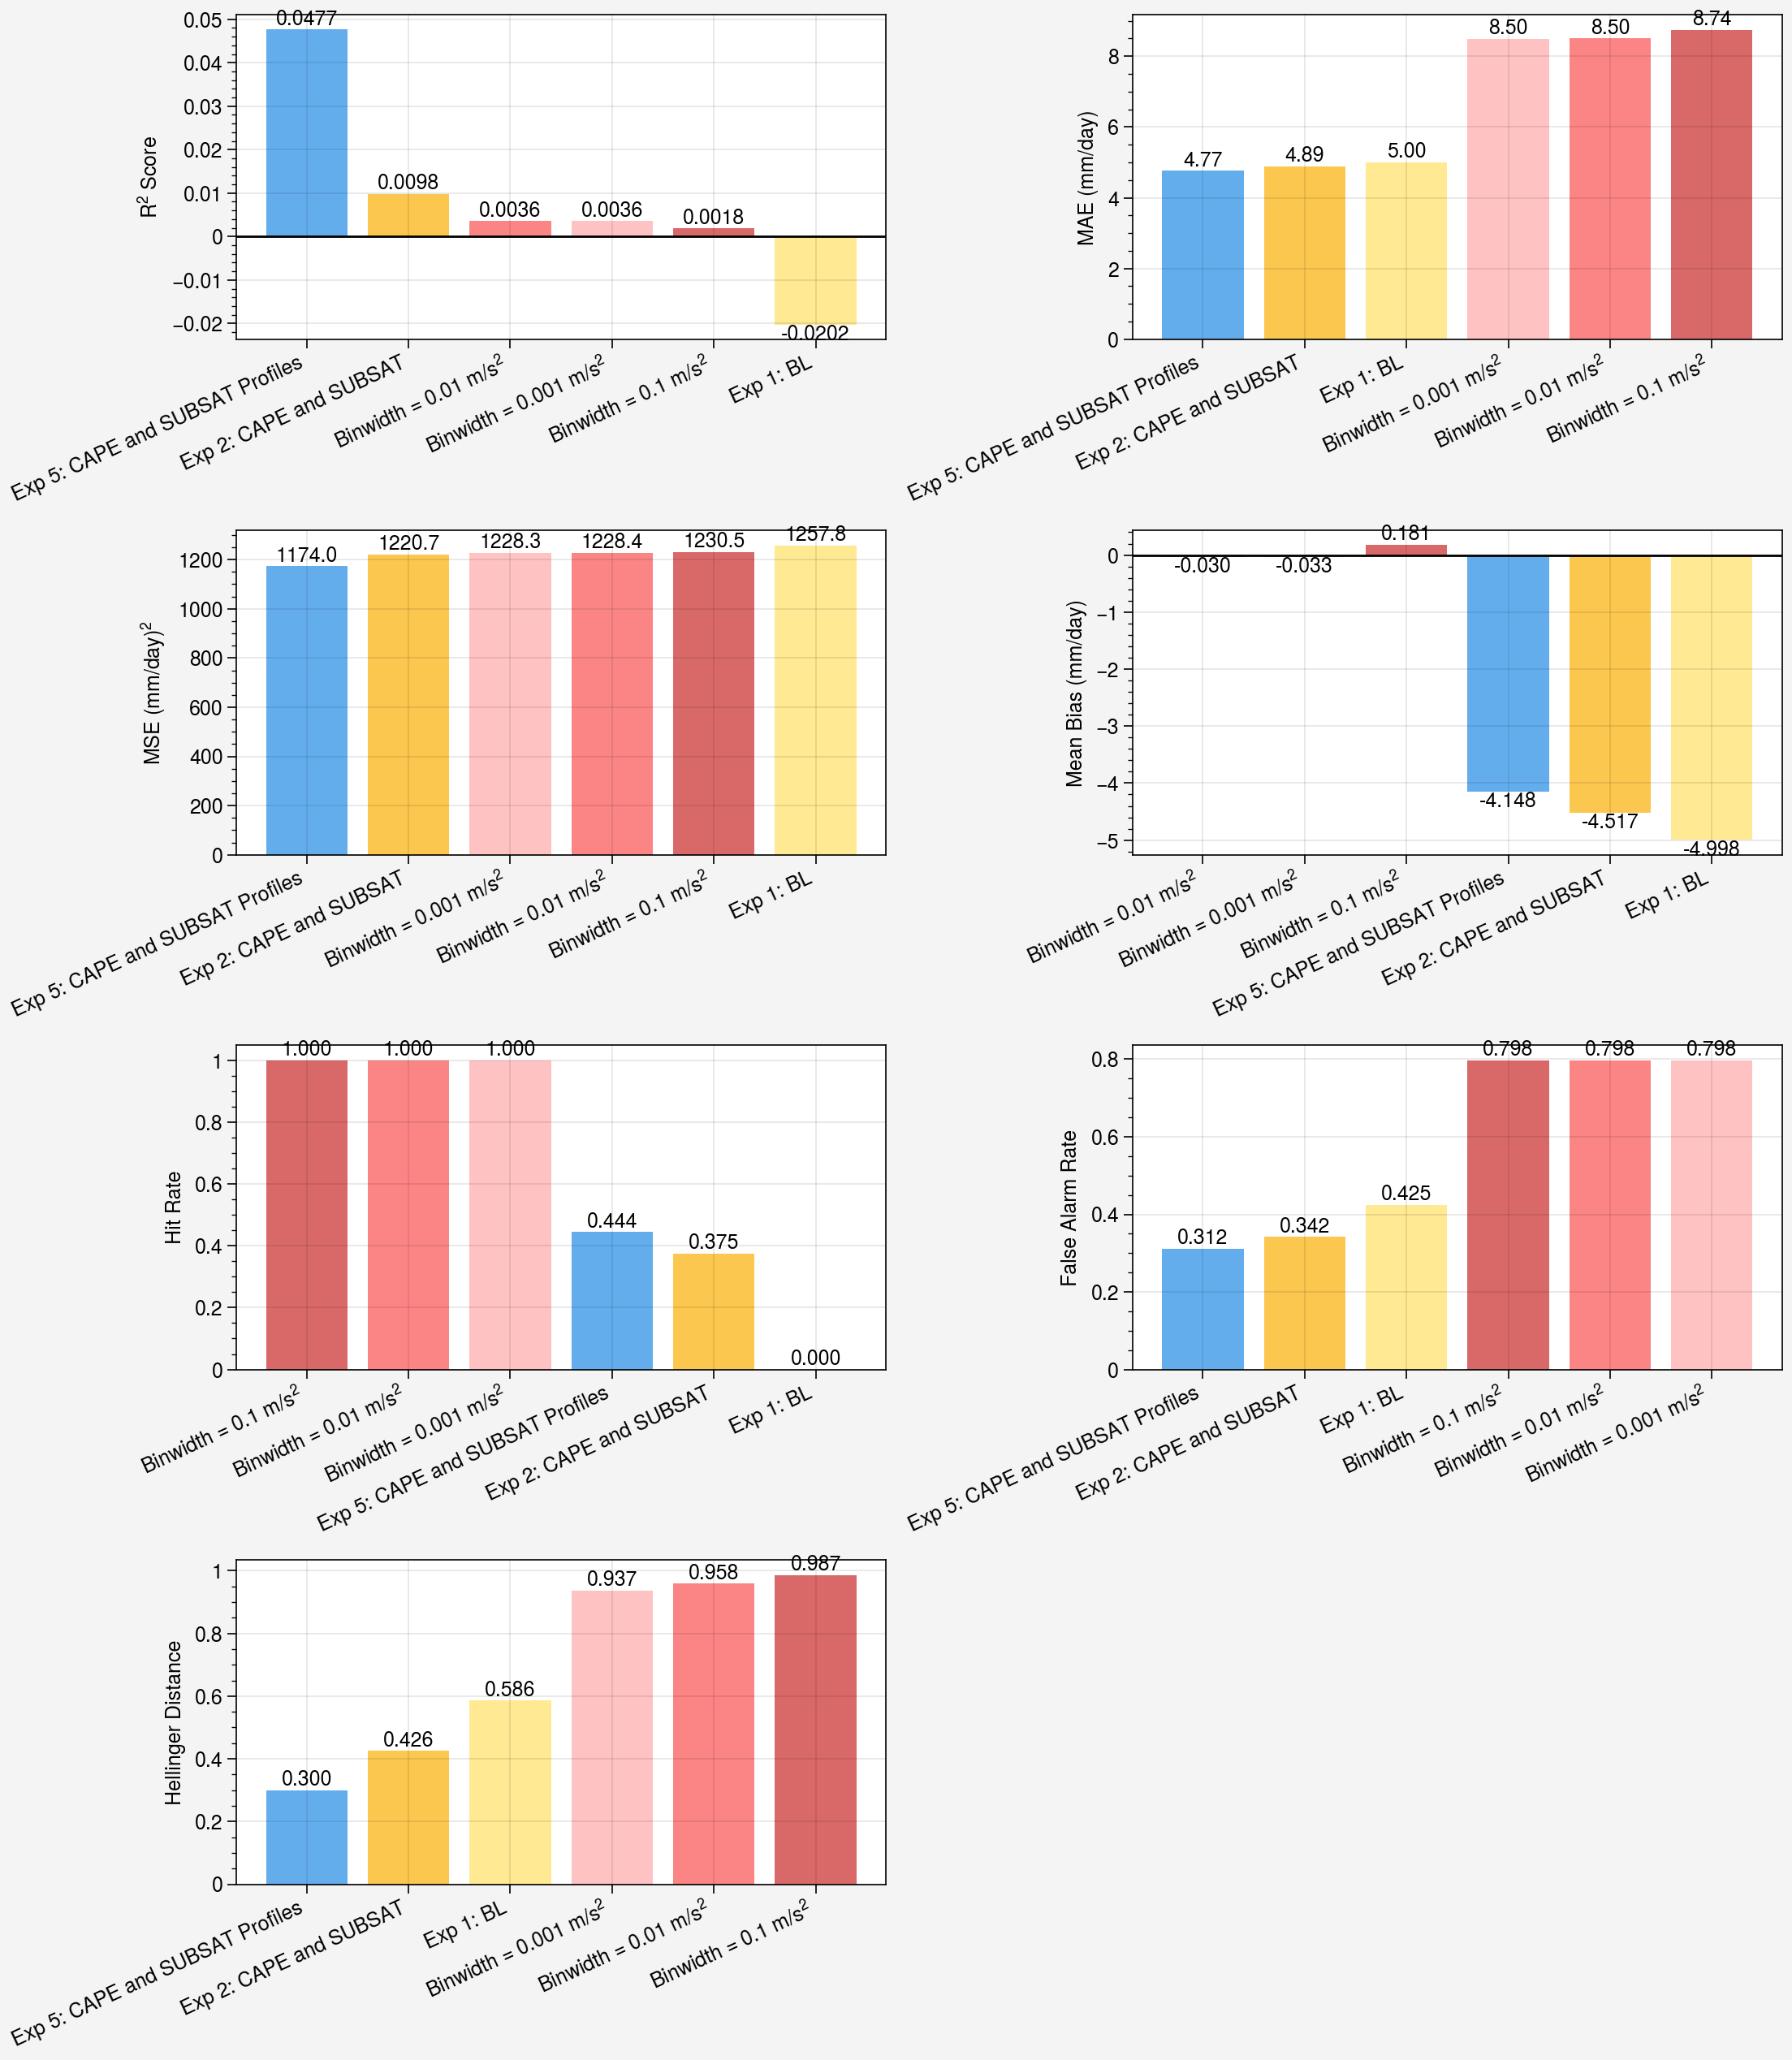

In [44]:
metricsconfig = {
    'r2': {'title':'R$^2$ Score','higher_better':True,'format':'.4f'},
    'mae':{'title':'MAE (mm/day)','higher_better':False,'format':'.2f'},
    'mse':{'title':'MSE (mm/day)$^2$','higher_better':False,'format':'.1f'},
    'bias':{'title':'Mean Bias (mm/day)','higher_better':None,'format':'.3f'},
    'hitrate':{'title':'Hit Rate','higher_better':True,'format':'.3f'},
    'far':{'title':'False Alarm Rate','higher_better':False,'format':'.3f'},
    'hellinger':{'title':'Hellinger Distance','higher_better': False,'format':'.3f'}}

ncols   = 2
nrows   = (len(metricsconfig)+ncols-1)//ncols
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=4,refheight=2,share=False)

for i,(metric,config) in enumerate(metricsconfig.items()):
    row = i//ncols
    col = i%ncols
    if config['higher_better'] is True:
        sorteddf = metricsdf.sort_values(metric, ascending=False)
    elif config['higher_better'] is False:
        sorteddf = metricsdf.sort_values(metric, ascending=True)
    else:
        sorteddf = metricsdf.sort_values(metric, key=abs, ascending=True)
    
    colors = [get_model_color(name) for name in sorteddf['name']]
    bars = axs[row,col].bar(range(len(sorteddf)),sorteddf[metric],color=colors,alpha=0.7)
    axs[row,col].format(ylabel=config['title'],xminorticks='none')
    if metric=='r2' or metric=='bias':
        axs[row,col].axhline(y=0,color='k',linewidth=1)
    
    for j,(bar,value) in enumerate(zip(bars,sorteddf[metric])):
        height = bar.get_height()
        va   = 'bottom' if height>=0 else 'top'
        ypos = height if height>=0 else height
        axs[row,col].text(bar.get_x()+bar.get_width()/2.,ypos,f'{value:{config["format"]}}',ha='center',va=va)
    axs[row,col].set_xticks(range(len(sorteddf)))
    axs[row,col].set_xticklabels([d for d in sorteddf['description']],ha='right',rotation=25)

for i in range(len(metricsconfig),nrows*ncols):
    row = i//ncols
    col = i%ncols
    axs[row,col].axis('off')

pplt.show()

## Plot Pareto Front

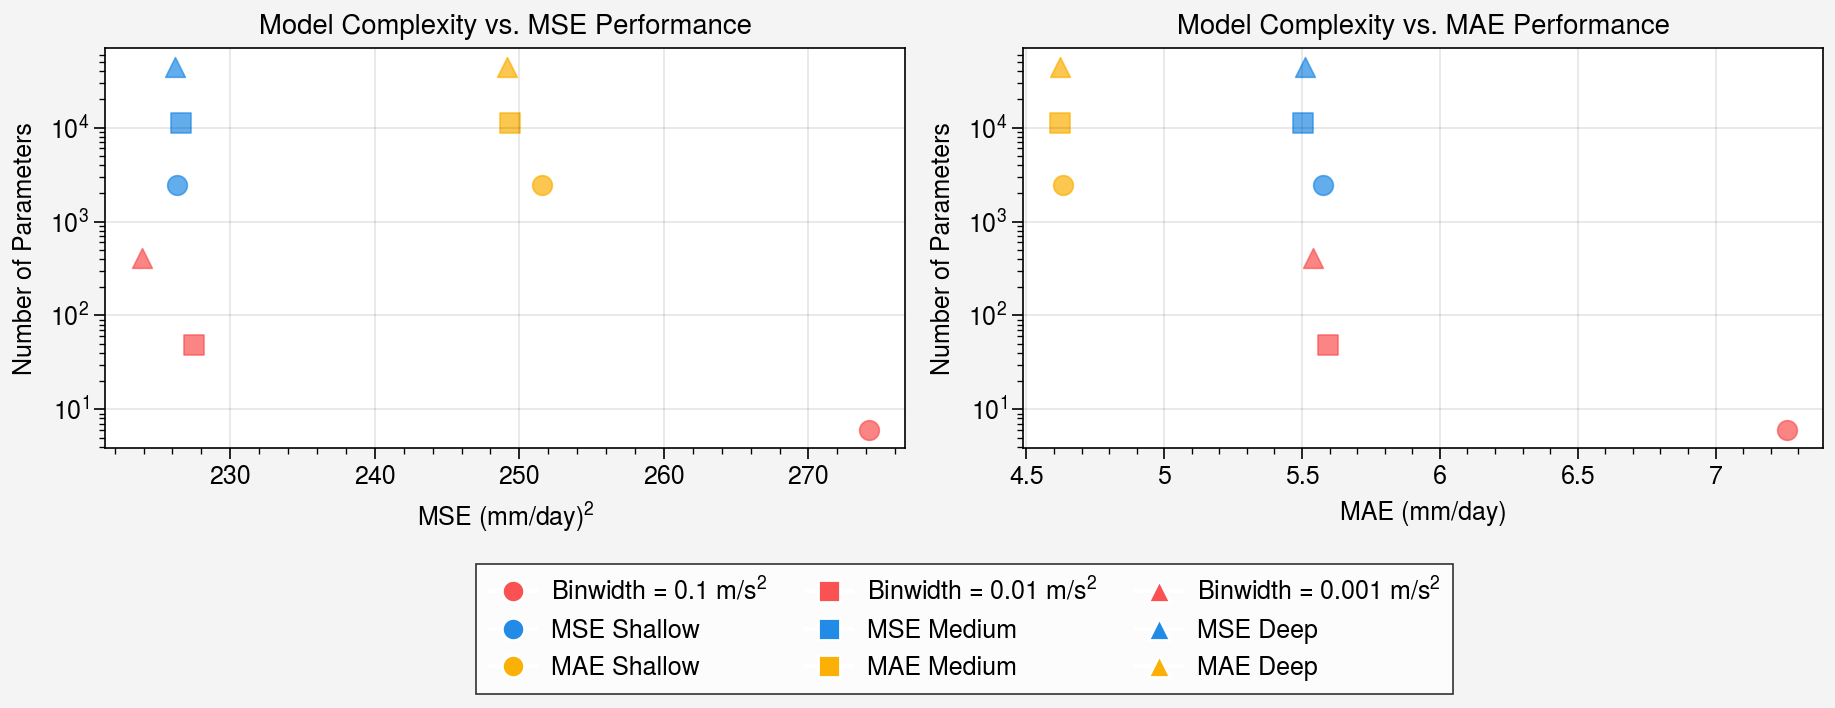

In [27]:
fig,axs = pplt.subplots(nrows=1,ncols=2,refwidth=4,refheight=2,share=False)

axs[0].format(title='Model Complexity vs. MSE Performance',
              xlabel='MSE (mm/day)$^2$',ylabel='Number of Parameters',yscale='log',yformatter='log')
axs[1].format(title='Model Complexity vs. MAE Performance',
              xlabel='MAE (mm/day)',ylabel='Number of Parameters',yscale='log',yformatter='log')

colors  = [get_model_color(name) for name in metricsdf['name']]
markers = [get_model_marker(name) for name in metricsdf['name']]

elements = []
for i,row in metricsdf.iterrows():
    axs[0].scatter(row['mse'],row['nparams'],color=colors[i], marker=markers[i],markersize=50,alpha=0.7)
    axs[1].scatter(row['mae'],row['nparams'],color=colors[i],marker=markers[i],markersize=50,alpha=0.7)
    elements.append(Line2D([0],[0],marker=markers[i],color='w',markerfacecolor=colors[i],markersize=8,label=row['description']))
fig.legend(handles=elements,loc='b',ncols=3)

pplt.show()